1. Install Required Libraries and Import Libraries

In [32]:
!pip install category_encoders ipywidgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE


2. Load, Preprocess Data and EDA

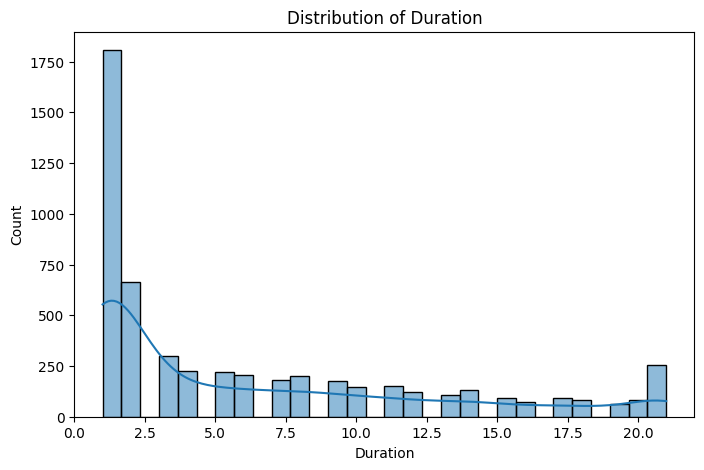

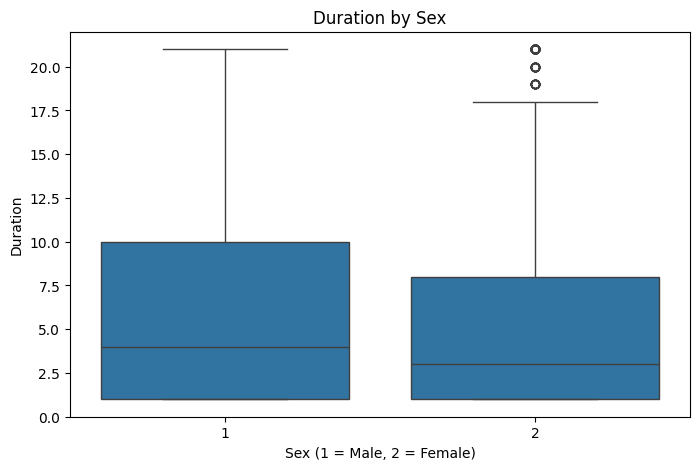

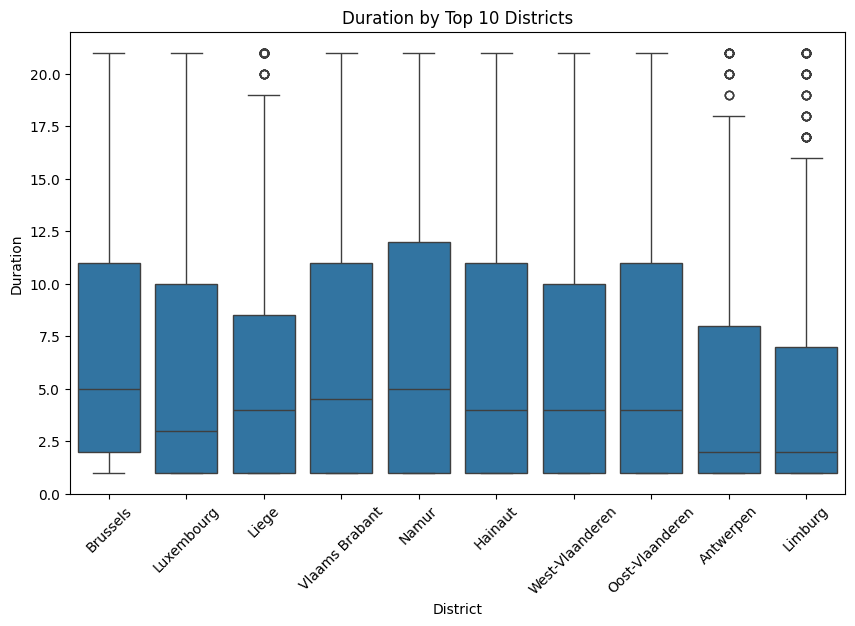

In [33]:
df = pd.read_excel("Improving_P&L_machineLearning.xlsx", sheet_name="AllianzDisabilityClaimDataset")

# Drop unnecessary columns
df.drop("Contract_number", axis=1, inplace=True)
df.drop("Postalcode", axis=1, inplace=True)

# Distribution of Duration
plt.figure(figsize=(8, 5))
sns.histplot(df['Duration'], kde=True, bins=30)
plt.title("Distribution of Duration")
plt.xlabel("Duration")
plt.ylabel("Count")
plt.show()

# Duration by Sex
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sex', y='Duration')
plt.title("Duration by Sex")
plt.xlabel("Sex (1 = Male, 2 = Female)")
plt.ylabel("Duration")
plt.show()

# Duration by Top 10 Districts
top_districts = df['District'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['District'].isin(top_districts)], x='District', y='Duration')
plt.title("Duration by Top 10 Districts")
plt.xticks(rotation=45)
plt.show()


3. Checking, Handling Missing Values & Encode Categorical Features

In [34]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values in each column:\n", missing_values)

# For categorical columns (e.g., 'Broker' and 'District'), we can impute using the mode (most frequent value)
df['Broker'].fillna(df['Broker'].mode()[0], inplace=True)

 # Check if there are any missing values left
missing_values_after = df.isnull().sum()
print("\nMissing Values After Imputation:\n", missing_values_after)

encoder = TargetEncoder(cols=['District'])
df['District'] = encoder.fit_transform(df['District'], df['Duration'])



Missing Values in each column:
 Sex              0
Birth_year       0
Birth_month      0
End_age          0
Claim_year       0
Claim_month      0
Pct_dis1         0
Pct_dis2         0
Pct_dis3         0
Pct_dis4         0
Pct_dis5         0
Pct_dis6         0
Pct_dis7         0
Pct_dis8         0
Pct_dis9         0
Pct_dis10        0
Pct_dis11        0
Pct_dis12        0
Pct_dis13        0
Pct_dis14        0
Pct_dis15        0
Pct_dis16        0
Pct_dis17        0
Pct_dis18        0
Pct_dis19        0
Pct_dis20        0
Pct_dis21        0
Duration         0
District         0
Broker         432
Annuity          0
dtype: int64

Missing Values After Imputation:
 Sex            0
Birth_year     0
Birth_month    0
End_age        0
Claim_year     0
Claim_month    0
Pct_dis1       0
Pct_dis2       0
Pct_dis3       0
Pct_dis4       0
Pct_dis5       0
Pct_dis6       0
Pct_dis7       0
Pct_dis8       0
Pct_dis9       0
Pct_dis10      0
Pct_dis11      0
Pct_dis12      0
Pct_dis13      0
Pct_dis1

<ipython-input-34-7567497c7760>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Broker'].fillna(df['Broker'].mode()[0], inplace=True)


4. Define Features and Train-Test Split

In [35]:
X = df.drop(columns=['Duration'])
y = df['Duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5. Random Forest with Grid Search

In [37]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt"]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring="neg_mean_squared_error",
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
78 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}


6. Detect and Remove Outliers from Predictions & its Visualization

Removed 72 outliers from test set.


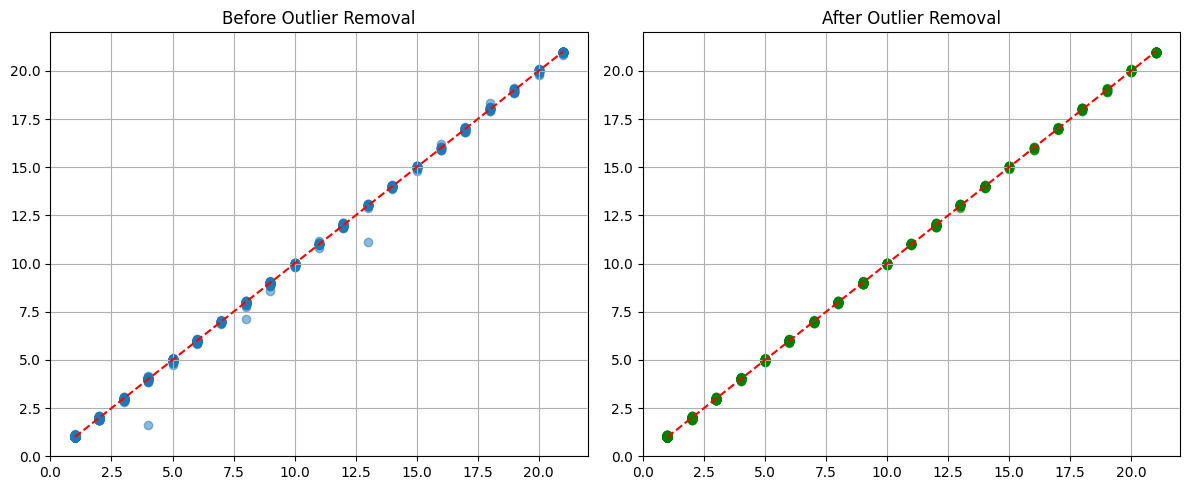

In [11]:
residuals = y_test - y_pred
df_res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals}, index=y_test.index)

Q1 = df_res['Residual'].quantile(0.25)
Q3 = df_res['Residual'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df_res[(df_res['Residual'] >= lower_bound) & (df_res['Residual'] <= upper_bound)]
print(f"Removed {len(df_res) - len(df_clean)} outliers from test set.")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_res['Actual'], df_res['Predicted'], alpha=0.5)
plt.title("Before Outlier Removal")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_clean['Actual'], df_clean['Predicted'], alpha=0.5, color='green')
plt.title("After Outlier Removal")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)

plt.tight_layout()
plt.show()


7. Model Evaluation on Test Set

In [12]:
y_pred = model.predict(X_test)

print("R2 Score on Test Set:", r2_score(y_test, y_pred))
print("RMSE on Test Set:", np.sqrt(mean_squared_error(y_test, y_pred)))

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f} years")
print(f"Mean Squared Error (MSE): {mse:.4f} (years²)")

R2 Score on Test Set: 0.999680608311718
RMSE on Test Set: 0.11043211216239616
Mean Absolute Error (MAE): 0.0410 years
Mean Squared Error (MSE): 0.0122 (years²)


8.  KDE Plot – Distribution Comparison

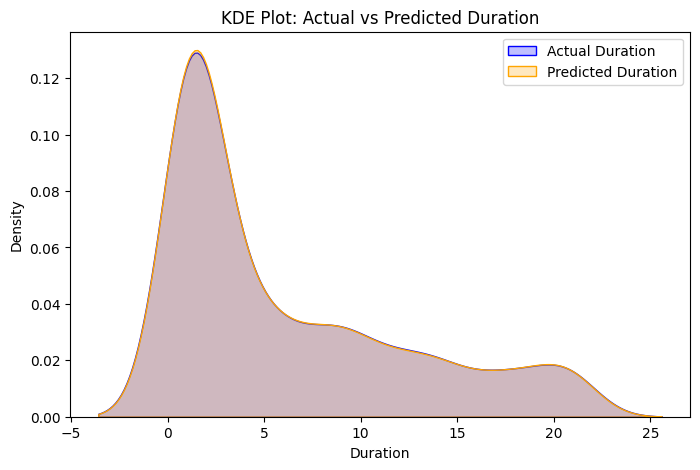

In [13]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, fill=True, color='blue', label='Actual Duration')
sns.kdeplot(y_pred, fill=True, color='orange', label='Predicted Duration')
plt.title("KDE Plot: Actual vs Predicted Duration")
plt.legend()
plt.show()


9. Interactive Duration Prediction (ipywidgets)

In [14]:
# Create widgets for each feature
widgets_dict = {}
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        widget = widgets.FloatText(description=col + ":", style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
    else:
        widget = widgets.Text(description=col + ":", style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
    widgets_dict[col] = widget


10.  Define Prediction Form Logic

In [15]:
submit_button = widgets.Button(description="Predict Duration", button_style='success', layout=widgets.Layout(width='300px'))
output = widgets.Output()

def on_submit(b):
    with output:
        clear_output()
        input_data = {}
        for col, widget_field in widgets_dict.items():
            val = widget_field.value
            try:
                input_data[col] = float(val) if pd.api.types.is_numeric_dtype(X[col]) else val
            except:
                input_data[col] = val
        new_sample = pd.DataFrame([input_data])
        if 'District' in new_sample.columns:
            new_sample['District'] = encoder.transform(new_sample['District'])
        prediction = model.predict(new_sample)[0]
        print(f"Predicted Duration: {prediction:.2f}")
        plt.figure(figsize=(8, 5))
        sns.kdeplot(df['Duration'], fill=True, color="skyblue", label='Existing Duration Distribution')
        plt.axvline(prediction, color='red', linestyle='--', linewidth=2, label='Predicted Duration')
        plt.title('Predicted Duration vs. Duration Distribution')
        plt.xlabel('Duration')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

submit_button.on_click(on_submit)
input_widgets = widgets.VBox(list(widgets_dict.values()) + [submit_button, output])
display(input_widgets)
